<a href="https://colab.research.google.com/github/hargurjeet/DeepLearning/blob/main/Fake_News_Classifer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import time
import seaborn as sns

from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import re
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
# Upload kaggle.jason
# please follow this link incase not aware: https://www.kaggle.com/general/74235
from google.colab import files
files.upload()

! pip install opendatasets --upgrade
import opendatasets as od

dataset_url = 'https://www.kaggle.com/clmentbisaillon/fake-and-real-news-dataset'
od.download(dataset_url)

Saving kaggle.json to kaggle (1).json
Requirement already up-to-date: opendatasets in /usr/local/lib/python3.7/dist-packages (0.1.13)


100%|██████████| 41.0M/41.0M [00:00<00:00, 241MB/s]

In [4]:
real_news = pd.read_csv('/content/fake-and-real-news-dataset/True.csv')
fake_news = pd.read_csv('/content/fake-and-real-news-dataset/Fake.csv')
real_news.head(5)

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [5]:
fake_news.head(5)

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [6]:
print(real_news.shape)
print(fake_news.shape)

(21417, 4)
(23481, 4)


In [7]:
real_news['FakeOrNot'] = 1
fake_news['FakeOrNot'] = 0

In [8]:
News_Dataset = pd.concat([real_news, fake_news], ignore_index=True)
News_Dataset.head()

,title,text,subject,date,FakeOrNot
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


In [9]:
News_Dataset.shape

(44898, 5)

In [10]:
News_Dataset.columns

Index(['title', 'text', 'subject', 'date', 'FakeOrNot'], dtype='object')

In [11]:
News_Dataset = News_Dataset.drop(['text', 'subject', 'date'], axis = 1)
News_Dataset

,title,FakeOrNot
0,"As U.S. budget fight looms, Republicans flip t...",1
1,U.S. military to accept transgender recruits o...,1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,1
3,FBI Russia probe helped by Australian diplomat...,1
4,Trump wants Postal Service to charge 'much mor...,1
...,...,...
44893,McPain: John McCain Furious That Iran Treated ...,0
44894,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,0
44895,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,0
44896,How to Blow $700 Million: Al Jazeera America F...,0


In [12]:
News_Dataset.FakeOrNot.value_counts()

0    23481
1    21417
Name: FakeOrNot, dtype: int64

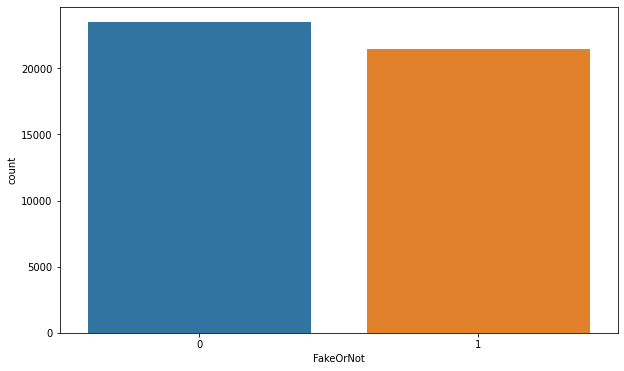

In [13]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.countplot(data = News_Dataset, x='FakeOrNot')
plt.show()

In [15]:
News_Dataset[News_Dataset.isnull().any(axis=1)]

,title,FakeOrNot


In [17]:
News_Dataset.title.replace("[^a-zA-Z]"," ",regex=True, inplace=True)

In [22]:
News_Dataset

,title,FakeOrNot
0,As U S budget fight looms Republicans flip their fiscal script,1
1,U S military to accept transgender recruits on Monday Pentagon,1
2,Senior U S Republican senator Let Mr Mueller do his job,1
3,FBI Russia probe helped by Australian diplomat tip off NYT,1
4,Trump wants Postal Service to charge much more for Amazon shipments,1
...,...,...
44893,McPain John McCain Furious That Iran Treated US Sailors Well,0
44894,JUSTICE Yahoo Settles E mail Privacy Class action M for Lawyers for Users,0
44895,Sunnistan US and Allied Safe Zone Plan to Take Territorial Booty in Northern Syria,0
44896,How to Blow Million Al Jazeera America Finally Calls it Quits,0


In [23]:
pd.set_option('display.max_colwidth', None)
News_Dataset.title = News_Dataset.title.str.lower()

In [24]:
News_Dataset[:10]

,title,FakeOrNot
0,as u s budget fight looms republicans flip their fiscal script,1
1,u s military to accept transgender recruits on monday pentagon,1
2,senior u s republican senator let mr mueller do his job,1
3,fbi russia probe helped by australian diplomat tip off nyt,1
4,trump wants postal service to charge much more for amazon shipments,1
5,white house congress prepare for talks on spending immigration,1
6,trump says russia probe will be fair but timeline unclear nyt,1
7,factbox trump on twitter dec approval rating amazon,1
8,trump on twitter dec global warming,1
9,alabama official to certify senator elect jones today despite challenge cnn,1


In [30]:
ps = PorterStemmer()
corpus = []
for i in range(0, len(News_Dataset)):
    review = re.sub('[^a-zA-Z]', ' ', News_Dataset['title'][i])
    review = review.lower()
    review = review.split()
    
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus.append(review)

In [31]:
corpus[3]

'fbi russia probe help australian diplomat tip nyt'